0.0
120.0
180.0
240.0
300.0
60.0
[-0.46586587 -0.00600601  0.87797798  0.75785786 -0.12212212 -0.63003003
  0.        ] [  0. 120. 180. 240. 300.  60.   0.]


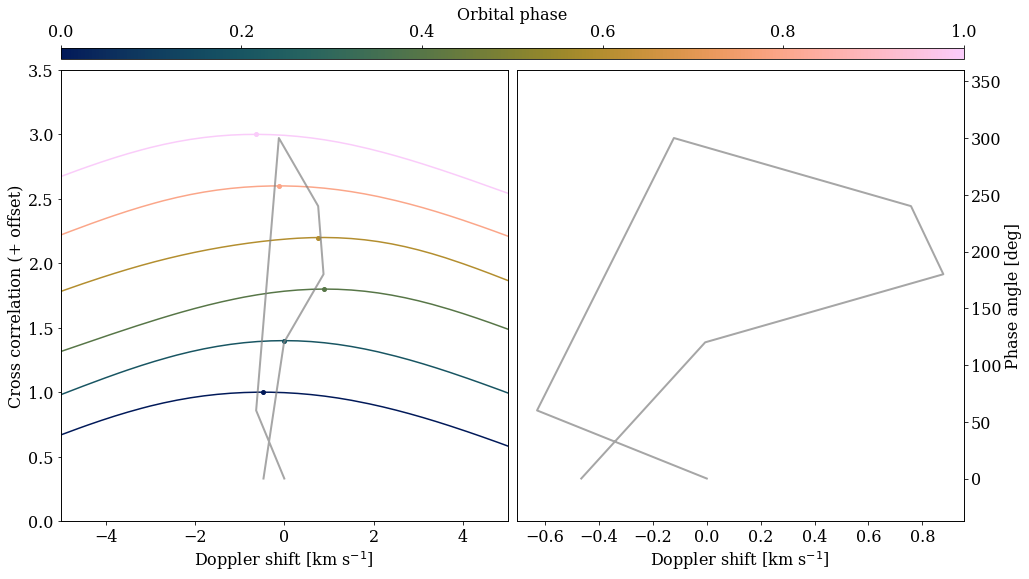

In [23]:
'''

Caleb Harada

plot CCFs for multiple phases and overplot RV as a function of phase


'''


import numpy as np
from PyAstronomy import pyasl
from scipy.optimize import curve_fit
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import glob
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable




### ----- INPUT/OUTPUT ----- ###

savefile = '/home/imalsky/Desktop/ccfs.png'




### ----- GET FILES ----- ###

#clear_files_dopp = f'/Users/calebharada/3D_RT_Code/2stream_new/OUT/clear/*_dopp-ON_phase-*.dat'
#clear_files_rest = f'/Users/calebharada/3D_RT_Code/2stream_new/OUT/clear/*_dopp-OFF_phase-*.dat'

#extended_thick_files_dopp = f'/Users/calebharada/3D_RT_Code/2stream_new/OUT/extended_thick/*_dopp-ON_phase-*.dat'
#extended_thick_files_rest = f'/Users/calebharada/3D_RT_Code/2stream_new/OUT/extended_thick/*_dopp-OFF_phase-*.dat'

clear_files_dopp = f'/home/imalsky/Desktop/SPECTRA/Spec_1_UPS-BIG-G-CLEAR-250_phase_*_inc_0.0000.00.dat'
clear_files_rest = f'/home/imalsky/Desktop/SPECTRA/Spec_0_UPS-BIG-G-CLEAR-250_phase_*_inc_0.0000.00.dat'

extended_thick_files_dopp = f'/home/imalsky/Desktop/SPECTRA/Spec_1_UPS-BIG-G-CLEAR-250_phase_*_inc_0.0000.00.dat'
extended_thick_files_rest = f'/home/imalsky/Desktop/SPECTRA/Spec_0_UPS-BIG-G-CLEAR-250_phase_*_inc_0.0000.00.dat'

# set up CCF figure
font = {'size' : 16,
    'family' : 'serif'}
plt.rc('font', **font)

fig, axes = plt.subplots(1, 2, figsize=(16.18, 10))
plt.subplots_adjust(wspace=0.02, hspace=0)


# colormap
cm_name = 'batlow'
cm_file = np.loadtxt(f'/home/imalsky/Desktop/batlow/batlow.txt')
my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)


def dopp_signatures(templates, signals, axis, phase_fmt='int'):

    ### ----- LOAD DATA ----- ###

    templates = sorted(glob.glob(templates))
    signals = sorted(glob.glob(signals))

    phases = np.zeros(len(templates) + 1)
    RVs = np.zeros(len(templates) + 1)

    axis.set_xlim([-5, 5])
    axis.set_ylim([0, 3.5])

    # list of colors
    colors = np.linspace(0, 1, len(templates))

    # keep track of color and offset
    color_idx = 0
    offset = 0


    for i in range(len(templates)):
        
        
        # save orbital
        if phase_fmt == 'int':
            phase = int(templates[i][-7:-4])
        elif phase_fmt == 'float':
            temp = templates[i][-23:-18]
            
            if temp[0] == '_':
                temp = temp[1:]
            elif temp[0] == 'e':
                temp = temp[2:]

            phase = float(temp)
        else:
            print('ERROR\n Unrecognized phase format.')
            exit()

        phases[i] = phase
        print (phase)


        tw, tf = np.loadtxt(templates[i], unpack=True)
        dw, df = np.loadtxt(signals[i], unpack=True)
        #print(np.sum(tf))
        
        # Carry out the cross-correlation.
        # The RV-range is -10 to +10 km/s in steps of 0.1 km/s.
        # The first and last 200 points of the data are skipped.
        rv, cc = pyasl.crosscorrRV(dw, df, tw, tf, -10., 10., 0.1, mode='lin', skipedge=200)

        # normalize cc function 
        cc = (cc - min(cc)) / (max(cc) - min(cc))

        # Find the index of maximum cross-correlation function
        maxind = np.argmax(cc)

        # define Gaussian function
        def gaussian(x, a, x0, sigma):
            return a * np.exp(-(x - x0) * (x - x0) / (2 * sigma * sigma))


        # fit Guassian to peak region of cc function
        rv_range = rv[maxind - 20: maxind + 20]
        cc_range = cc[maxind - 20: maxind + 20]

        popt, pcov = curve_fit(gaussian, rv_range, cc_range, p0=[1, 0, 1])

        # calculate best fit guassian
        rv_fit = np.linspace(rv[maxind - 20], rv[maxind + 20], 1000)
        cc_fit = gaussian(rv_fit, *popt)


        # index of maximum of Gaussian
        max_gauss = np.argmax(cc_fit)

        # save radial velocity
        RVs[i] = rv_fit[max_gauss]

        # plot CCFs
        axis.plot(rv, cc + offset, lw=1.5, color=my_colors(colors[color_idx]))
        axis.plot(rv_fit[max_gauss], cc_fit[max_gauss] + offset, '.', ms=8, color=my_colors(colors[color_idx]))


        offset += 0.4
        color_idx += 1



    #phases[-1] = 360
    #RVs[-1] = RVs[0]


    print (RVs, phases)
    return RVs, phases
    



# phase_fmt must be int for clear case (sorry)
clear_RVs, clear_phases = dopp_signatures(clear_files_rest, clear_files_dopp, axes[0], phase_fmt='float')
#cloudy_RVs, cloudy_phases = dopp_signatures(extended_thick_files_rest, extended_thick_files_dopp, axes[1], phase_fmt='float')


# plot RV line for clear case
clear_ax = axes[0].twinx()
clear_ax.set_ylim([-37.5, 360])
clear_ax.set_zorder(2)
clear_ax.yaxis.set_ticklabels([])
clear_ax.yaxis.set_ticks([])
clear_ax.patch.set_visible(False)
clear_ax.plot(clear_RVs, clear_phases, 'gray', lw=2, alpha=0.7)
#clear_ax.plot(clear_RVs, clear_phases - 360, 'gray', lw=2, alpha=0.7)


# plot RV line for cloudy case
cloudy_ax = axes[1].twinx()
cloudy_ax.set_ylim([-37.5, 360])
cloudy_ax.set_zorder(2)
cloudy_ax.patch.set_visible(False)
cloudy_ax.plot(cloudy_RVs, cloudy_phases, 'gray', lw=2, alpha=0.7)
cloudy_ax.plot(cloudy_RVs, cloudy_phases - 360, 'gray', lw=2, alpha=0.7)

axes[1].yaxis.set_ticks([])

# lines
#clear_ax.axvline(0, color='k', lw=1.5, ls='-', zorder=0, alpha=0.6)
#cloudy_ax.axvline(0, color='k', lw=1.5, ls='-', zorder=0, alpha=0.6)

#clear_ax.axhline(0, color='k', lw=1.5, ls='--', zorder=0, alpha=0.6)
#cloudy_ax.axhline(0, color='k', lw=1.5, ls='--', zorder=0, alpha=0.6)
#cloudy_ax.annotate('transit', xy=(0, 0), xycoords='data', xytext=(7.5, -5), bbox=dict(boxstyle='square', facecolor='white'), horizontalalignment='right')

#clear_ax.axhline(180, color='k', lw=1.5, ls='--', zorder=0, alpha=0.6)
#cloudy_ax.axhline(180, color='k', lw=1.5, ls='--', zorder=0, alpha=0.6)
#cloudy_ax.annotate('eclipse', xy=(0, 180), xycoords='data', xytext=(7.5, 175), bbox=dict(boxstyle='square', facecolor='white'), horizontalalignment='right')


# labels

axes[0].set_xlabel('Doppler shift [km s$^{-1}$]')
axes[1].set_xlabel('Doppler shift [km s$^{-1}$]')
axes[0].set_ylabel('Cross correlation (+ offset)')

cloudy_ax.set_ylabel('Phase angle [deg]')



sm = plt.cm.ScalarMappable(cmap=my_colors, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), location='top', aspect=80, pad=0.02)
cbar.set_label('Orbital phase')



fig.savefig(savefile, bbox_inches='tight', dpi=300)
